In [ ]:
pip install segmentation_models_pytorch --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 KB 667.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 KB 2.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=f253f46e805e543923b65633fae5b1f2620a653869aeb1d691f48bc5b61e920d
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=ecc23ea6c1d1e181023e11902bbe184b9c80a697235aac005bdaf8790b93c954
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Note: you may need to restart the kernel to use u

In [ ]:
import os
import json
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.transforms as tfms
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from segmentation_models_pytorch import DeepLabV3Plus, Linknet, UnetPlusPlus, Unet 
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss

In [ ]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.layer(x)

In [ ]:
class unet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
        super(unet, self).__init__()
        
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        for feature in features:
            self.down.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        for feature in reversed(features):
            self.up.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.up.append(DoubleConv(feature*2, feature))
        
        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        for layer in self.down:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.up), 2):
            x = self.up[i](x)
            skip_connection = skip_connections[i//2]
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.up[i+1](concat_skip)
        return self.final_layer(x)

In [ ]:
def test():
    x = torch.randn((1, 1, 512, 512))#.to(device)
    model = unet()
    y_pred = model(x)
    print(x.shape)
    print(y_pred.shape)

In [ ]:
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)
    
def forward(self,g,x):
    g1 = self.W_g(g)
    x1 = self.W_x(x)
    psi = self.relu(g1+x1)
    psi = self.psi(psi)
    return x*psi

In [ ]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

In [ ]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        x = self.up(x)
        return x

In [ ]:
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

In [ ]:
class AttU_Net(nn.Module):
    def __init__(self,img_ch=1,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

In [ ]:
# model = AttU_Net()

In [ ]:
core_path = "../input/tgcovid/"
path = core_path + "data/data/"

In [ ]:
with open(core_path + 'training_data.json', 'r') as f:
    data_dict = json.load(f)
data = [entry['image'][:-3] for entry in data_dict]
# train_data, test_data = data[:33], data[33:]

In [ ]:
train_data = data

In [ ]:
def normalize(x):
    xmin = np.min(x)
    xmax = np.max(x)
    return (x - xmin) / (xmax - xmin + 1e-8)

In [ ]:
class CovidDataset(Dataset):
    def __init__(self, data, train):
        super().__init__()
        path_images = os.path.join(path, 'images')
        path_labels = os.path.join(path, 'labels')
        with open(core_path + 'training_data.json', 'r') as f:
            dict_data = json.load(f)
 
        self.X = []
        self.y = []
        self.transform = A.Compose([
                                    A.OneOf([
                                        A.RandomSizedCrop(min_max_height=(300, 512), height=512, width=512, p=0.5),
                                    ], p=0.3),    
                                    A.VerticalFlip(p=0.5),              
                                    A.RandomRotate90(p=0.5),
                                    A.HorizontalFlip(p=0.5),
                                    A.Rotate(p=0.3),
                                    A.OneOf([
                                                A.GaussianBlur(),
                                                A.CoarseDropout(),
                                            ], p=.2),
                                    A.OneOf([
                                        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.2),
                                        A.GridDistortion(p=0.5),
                                        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.3)                  
                                        ], p=0.25),
                                    A.RandomBrightnessContrast(p=0.25),    
                                    A.RandomGamma(p=0.2)
                                    ])
        for entry in tqdm(dict_data):
            if entry['image'][:-3] in data:
                image = nib.load(os.path.join(path_images, entry['image'][:-3])).get_fdata()
                label = nib.load(os.path.join(path_labels, entry['label'][:-3])).get_fdata()
                for i in range(image.shape[-1]):
                    self.X.append(image[:, :, i])
                    self.y.append(label[:, :, i])

    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = self.X[idx].astype('float32')
        mask = self.y[idx].astype(np.uint8)
        img = normalize(img) 
        result = self.transform(image=img, mask=mask)
        img, mask = result['image'], result['mask']
        img, mask = torch.Tensor(img).reshape(1, 512, 512), torch.Tensor(mask).reshape(1, 512, 512)
        return img, mask

In [ ]:
batch_size = 12
train_dataset = CovidDataset(data=train_data, train=True)
# test_dataset = CovidDataset(data=test_data, train=False)
train = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
# test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
model = UnetPlusPlus(in_channels=1, 
             classes=1,
             )

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
def save_model(model, optimizer, epoch):
    state = {
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
            }
    torch.save(state, f"state_upd_{epoch}.pth")
    

In [ ]:
device = torch.device('cuda:0')
model = model.to(device)

In [ ]:
def visualize_some_scans(model, test, threshold):
    def show_four_scans(y, flag):
        figure = plt.figure(figsize=(18, 18))
        y = (torch.sigmoid(y) > threshold).float() if flag else y
        for i in range(4):
            ax = figure.add_subplot(1, 4, i + 1)
            ax.imshow(y[i, 0, :, :].cpu().detach().numpy())
            plt.title('Результат модели' if flag else 'Настоящий снимок')

            
    model.eval()        
    for i, (X, y) in enumerate(test):
        if i == 26:
            X = X[:4, ..., ..., ...].to(device)
            y = y[:4, ..., ..., ...].to(device)
            y_pred = model(X)[:, 0, :, :].reshape(4, 1, 512, 512)#.cpu().reshape(4, 1, 512, 512)
            X, y = X.cpu(), y.cpu()
            break
    
    
    show_four_scans(y, flag=False)
    print()
    show_four_scans(y_pred, flag=True)
    del X, y, y_pred
    model.train()

In [ ]:
test_losses = []
train_losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.85)
scaler = GradScaler()
criterion1 = DiceLoss(mode='binary')
criterion2 = FocalLoss(mode='binary')

In [ ]:
state = torch.load("../input/11nbk/state_upd_180.pth")
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

In [ ]:
import pickle

In [ ]:
def save_losses(losses):
    with open('train_losses.pkl', 'wb') as f:
        pickle.dump(losses, f)
def load_losses(filename='train_losses.pkl'):
    with open(filename, 'rb') as f:
        losses = pickle.load(f)
    return losses

In [ ]:
train_losses = load_losses(filename='../input/11nbk/train_losses.pkl')

  0%|          | 0/187 [00:00<?, ?it/s]

Epoch 183 train mean loss 0.27154086622581125
Epoch 184 train mean loss 0.2777763017635024
Epoch 185 train mean loss 0.2501861027014222
Epoch 186 train mean loss 0.2712196666787049
Epoch 187 train mean loss 0.26910410746441354
Epoch 188 train mean loss 0.28142327141664586
Epoch 189 train mean loss 0.2522258323506037
Epoch 190 train mean loss 0.26830710970873994

Epoch 191 train mean loss 0.26879765780493325
Epoch 192 train mean loss 0.26915720902173107
Epoch 193 train mean loss 0.2721627971388039
Epoch 194 train mean loss 0.253075911883296
Epoch 195 train mean loss 0.2830026715963078
Epoch 196 train mean loss 0.2685933034659834
Epoch 197 train mean loss 0.2593246251258959
Epoch 198 train mean loss 0.26105388649710803
Epoch 199 train mean loss 0.25274978590623
Epoch 200 train mean loss 0.2701824161041929

Epoch 201 train mean loss 0.29420952269767053
Epoch 202 train mean loss 0.27910274870787044
Epoch 203 train mean loss 0.2656159147632227
Epoch 204 train mean loss 0.26635144159723806
E

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until



Epoch 291 train mean loss 0.22324425760712654
Epoch 292 train mean loss 0.2228850699485598
Epoch 293 train mean loss 0.22601456019822988
Epoch 294 train mean loss 0.2504391391581504
Epoch 295 train mean loss 0.23183757384208012
Epoch 296 train mean loss 0.24455233196656678
Epoch 297 train mean loss 0.2429649831274445
Epoch 298 train mean loss 0.22856559761874135
Epoch 299 train mean loss 0.23182398162841975
Epoch 300 train mean loss 0.22661139677509212

Epoch 301 train mean loss 0.24260286861298075
Epoch 302 train mean loss 0.23405530029104366
Epoch 303 train mean loss 0.2357147978518266
Epoch 304 train mean loss 0.24017806166914213
Epoch 305 train mean loss 0.23496904165225915
Epoch 306 train mean loss 0.22787542857974966
Epoch 307 train mean loss 0.21997229916588024
Epoch 308 train mean loss 0.23554675075222065
Epoch 309 train mean loss 0.22760508973344362
Epoch 310 train mean loss 0.22667207269665998

Epoch 311 train mean loss 0.22971133940417213
Epoch 312 train mean loss 0.2256884

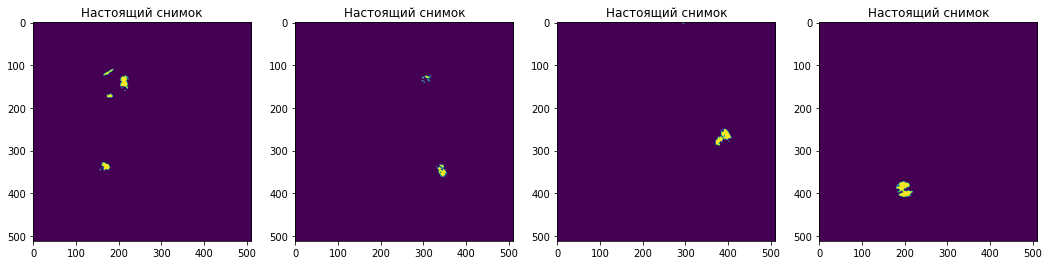

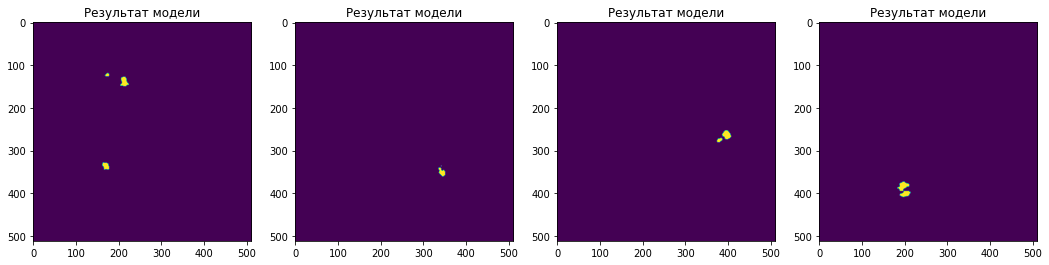

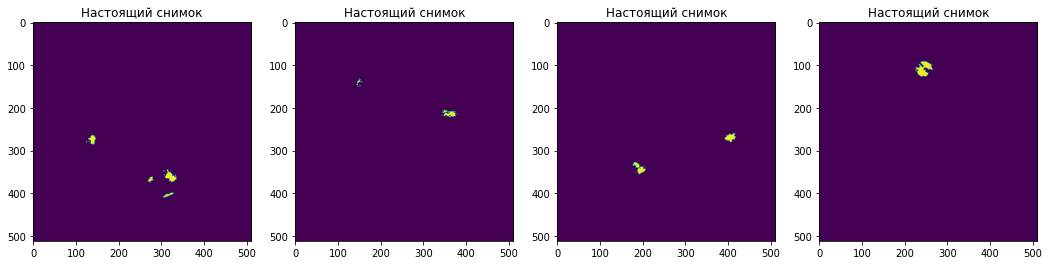

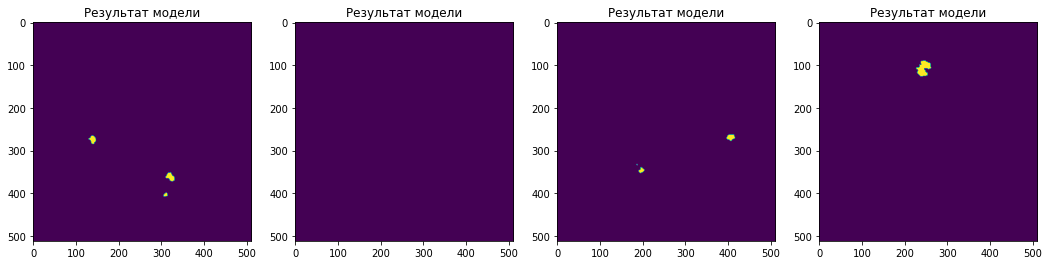

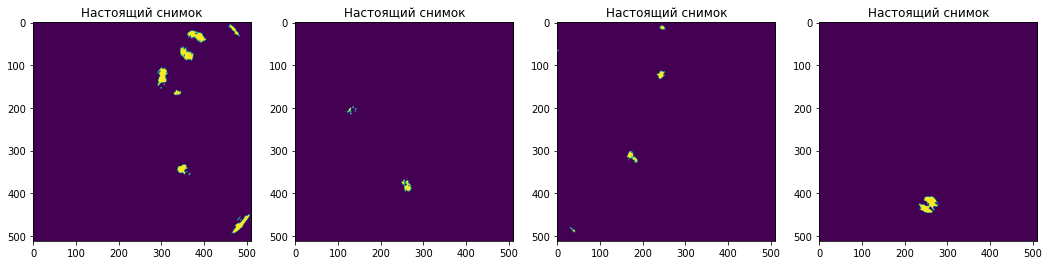

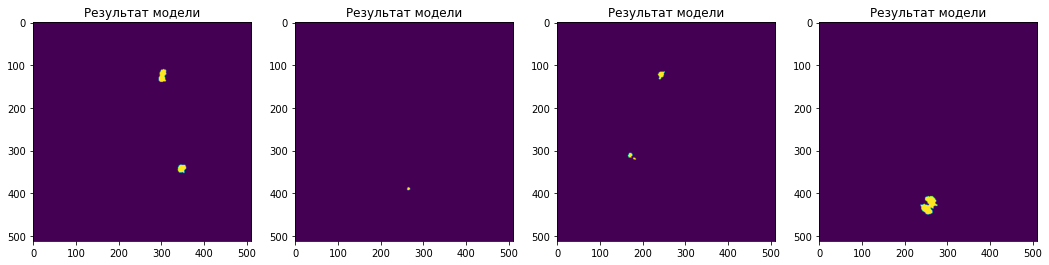

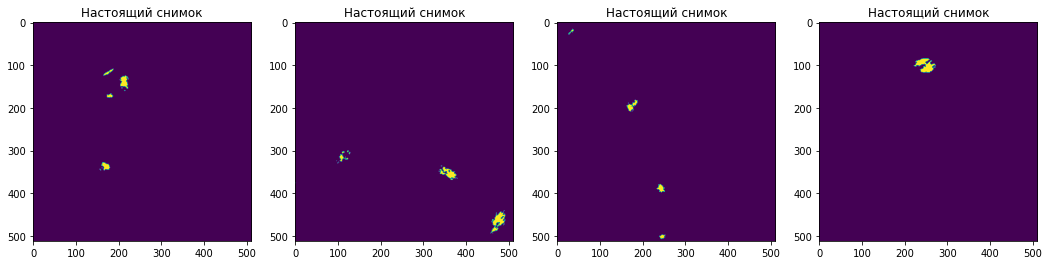

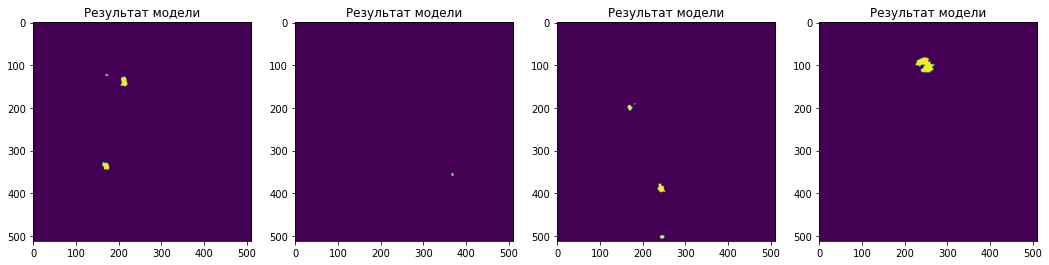

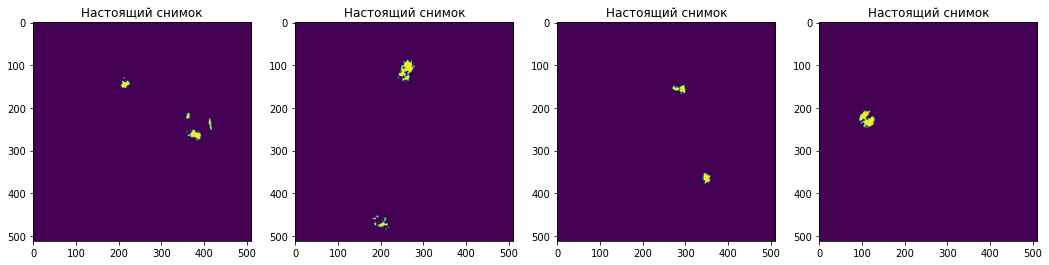

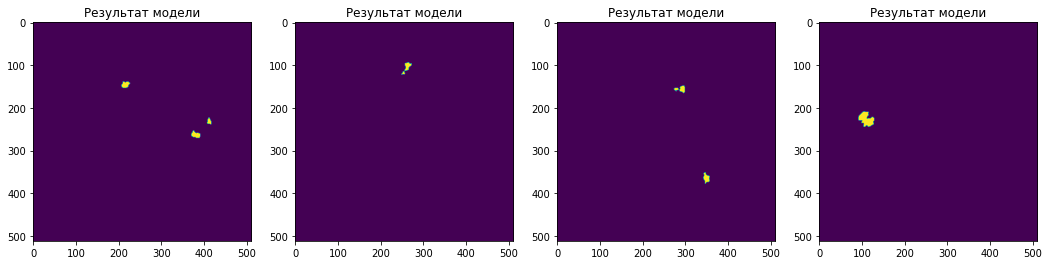

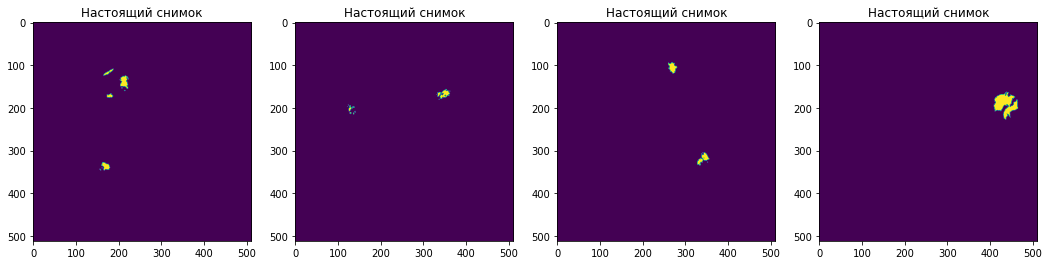

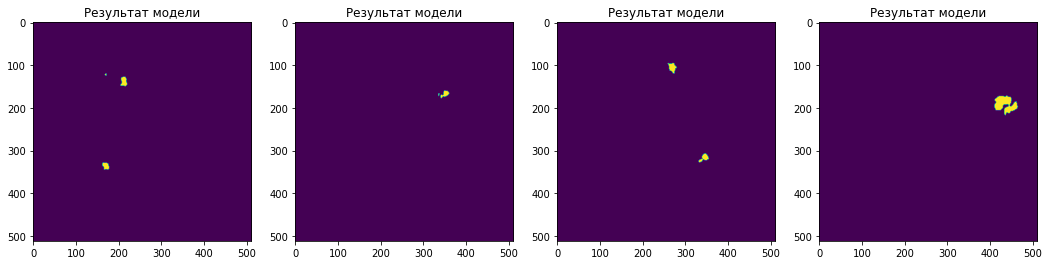

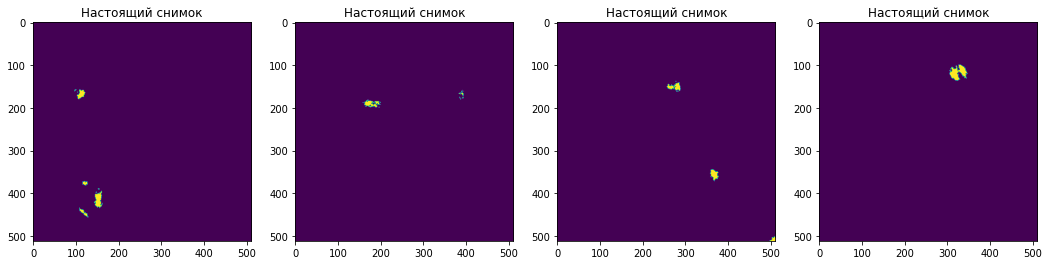

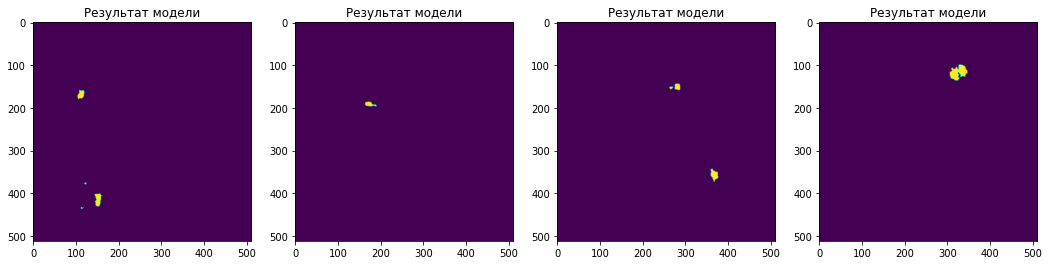

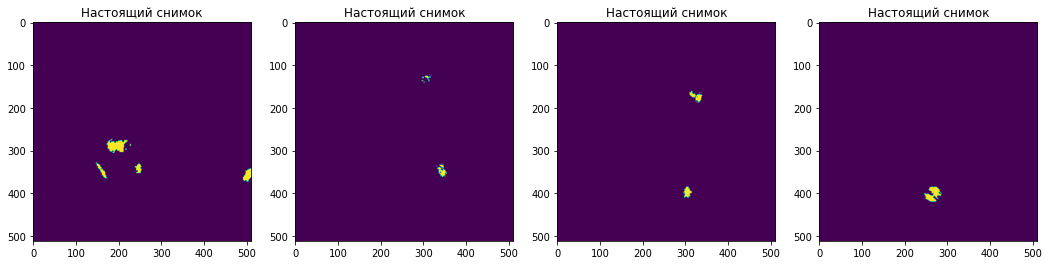

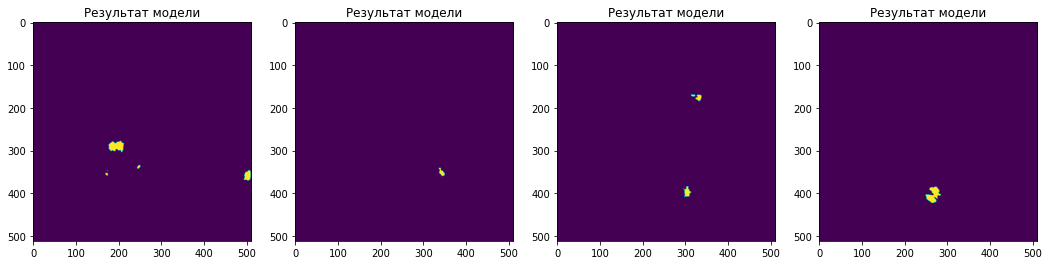

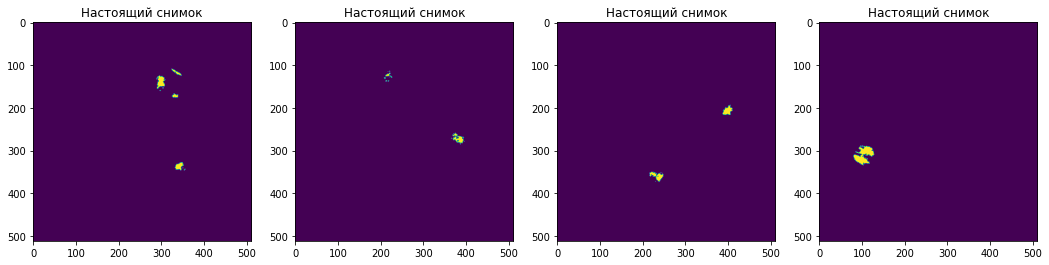

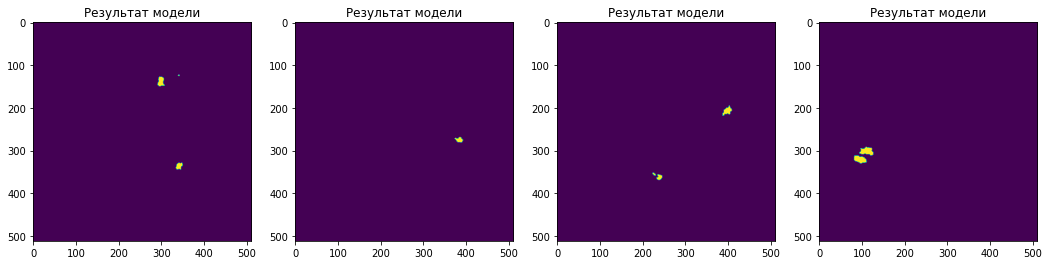

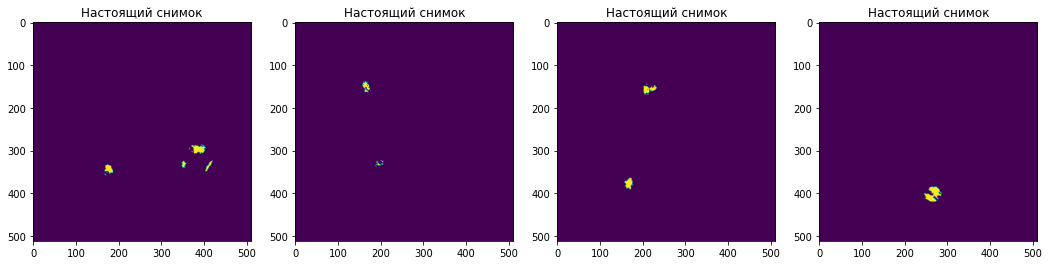

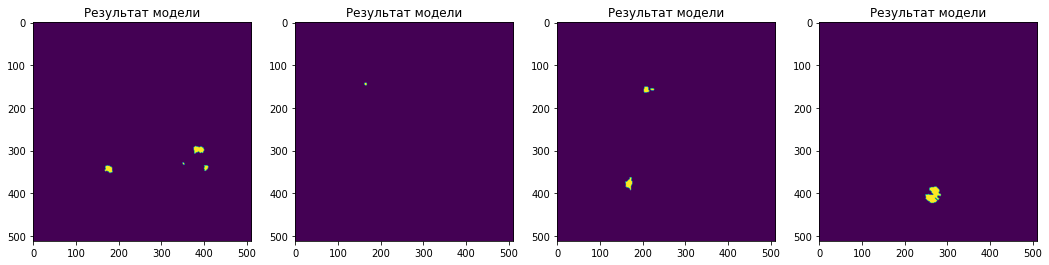

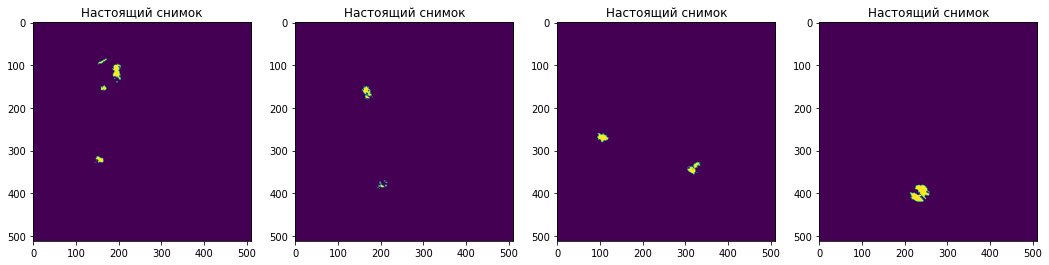

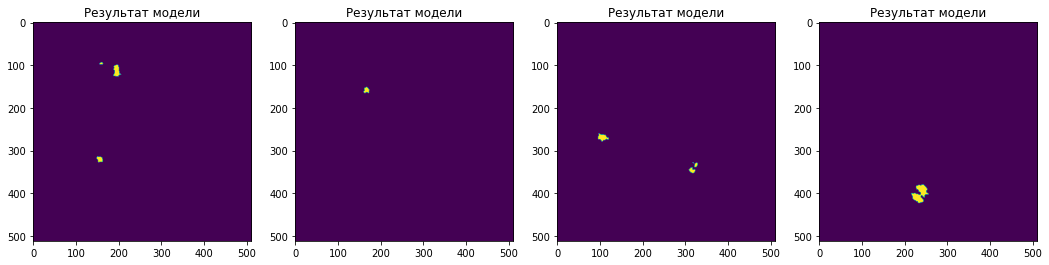

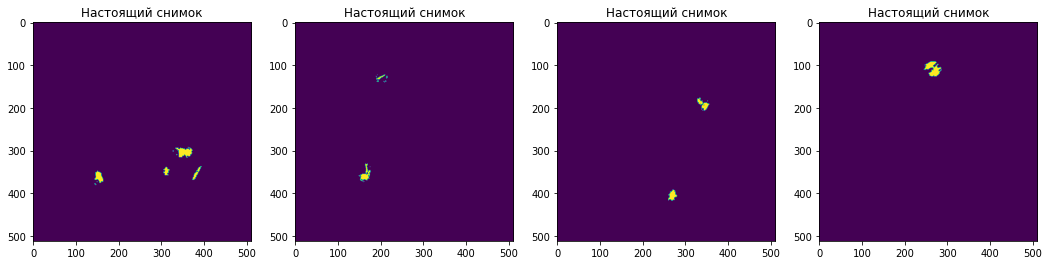

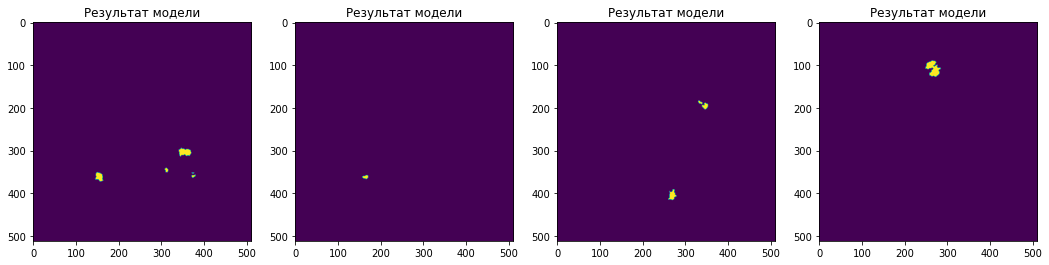

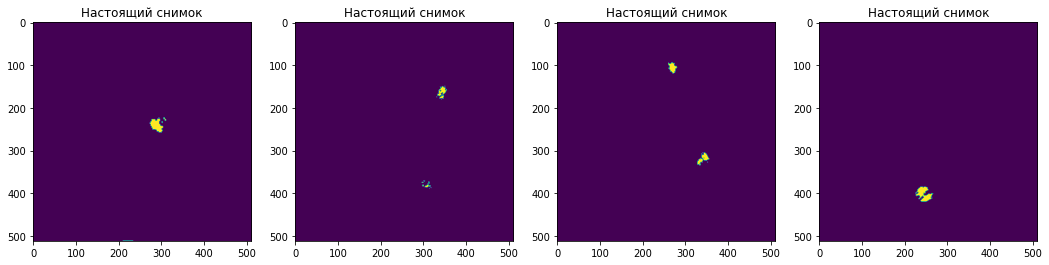

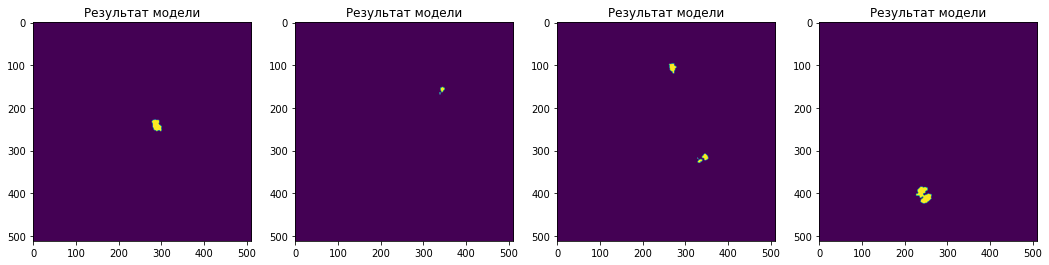

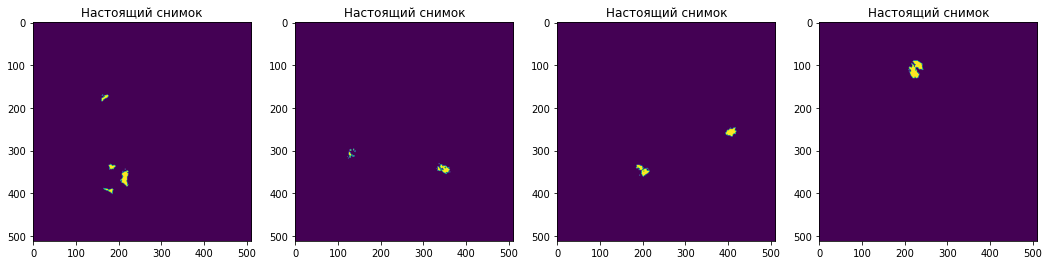

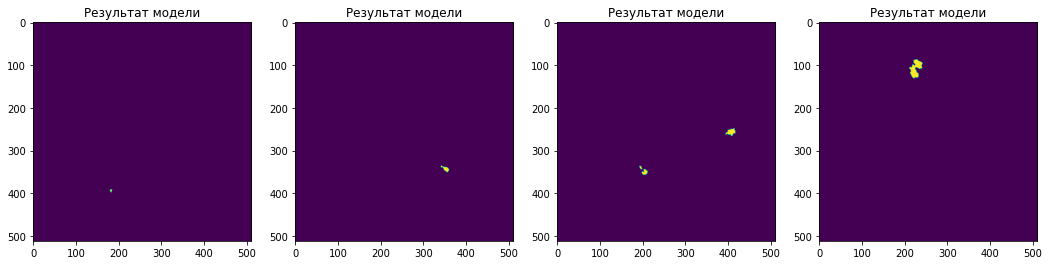

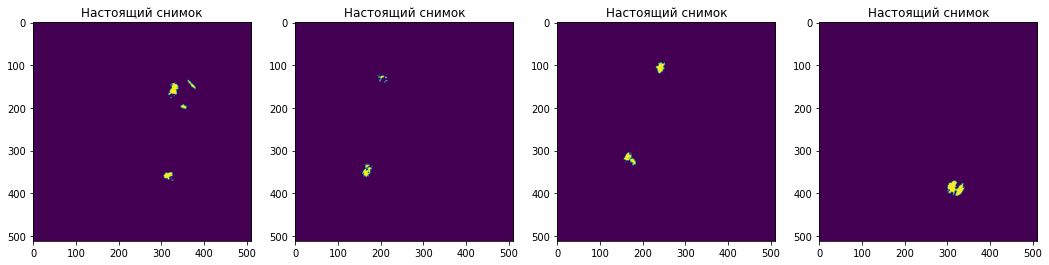

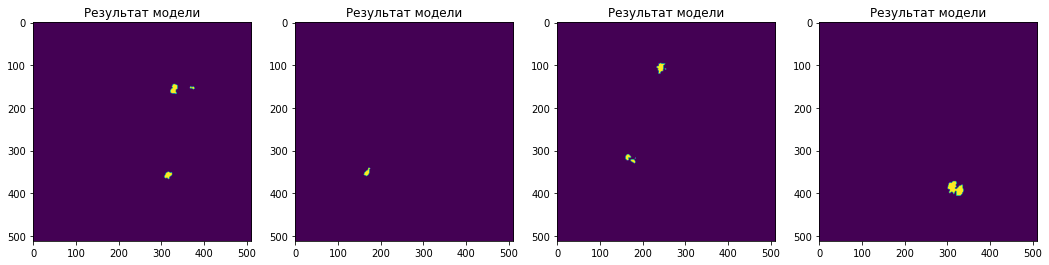

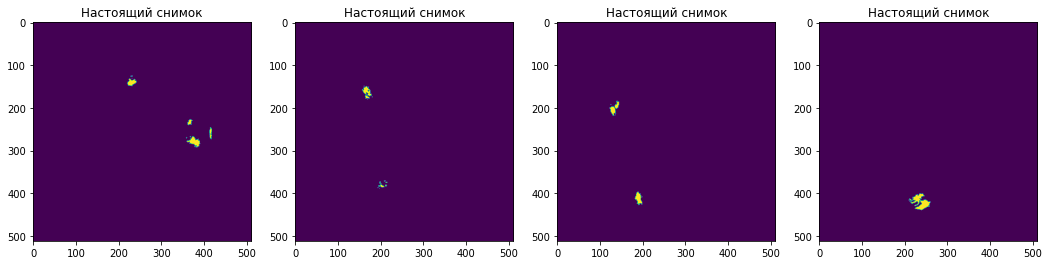

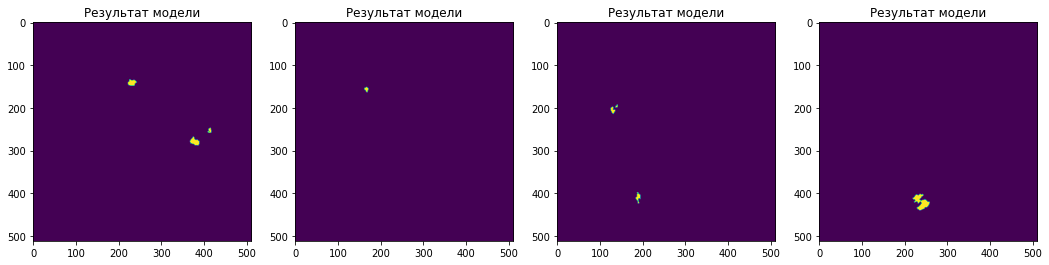

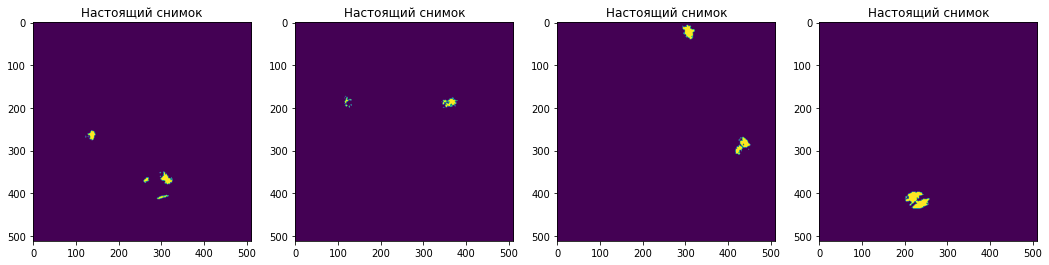

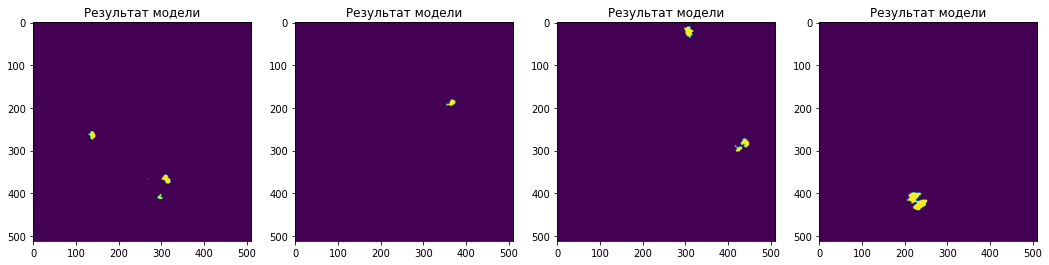

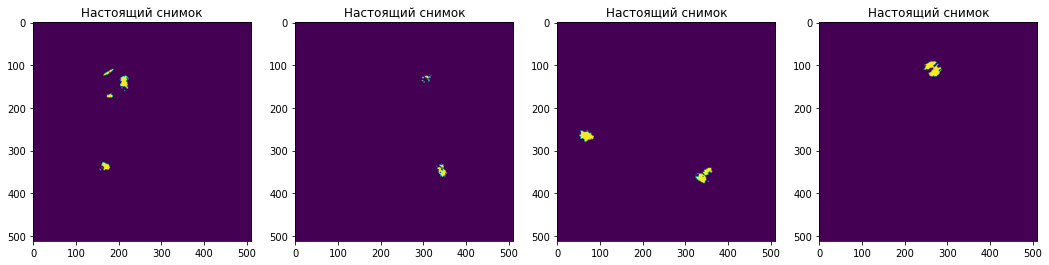

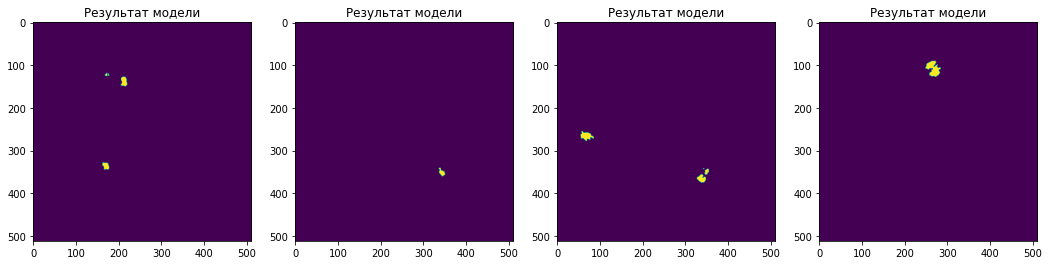

In [ ]:
for epoch in tqdm(range(183, 370)):
    epoch_losses = np.empty(shape=(0,))
    for X, y in train:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        with autocast():
            y_pred = model(X)
            loss = criterion1(y_pred, y) + criterion2(y_pred, y)
        epoch_losses = np.append(epoch_losses, [loss.item()])
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    sched.step()
        
    del X, y, y_pred
    train_losses.append(epoch_losses.mean()) 
    print(f'Epoch {epoch} train mean loss', epoch_losses.mean())
    if epoch % 10 == 0:
        visualize_some_scans(model, train, threshold=0.975)
    if epoch % 4 == 0:   
        save_model(model, optimizer, epoch)
    if epoch % 4 == 0:
        save_losses(train_losses)

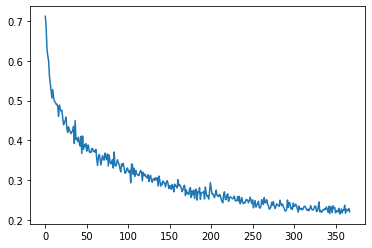

In [ ]:
plt.plot(train_losses)

In [ ]:
with open(core_path + 'testing_data.json', 'r') as f:
    dict_testing = json.load(f)

images_testing = []
for entry in tqdm(dict_testing):
    image = nib.load(os.path.join(path + "images/", entry['image'][:-3]))
    images_testing.append(image.get_fdata())

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
labels_predicted = []
model.eval()
for id in range(len(images_testing)):
    num_of_images = images_testing[id].shape[-1]
    result_for_id = []
    for i in range(num_of_images):
        image = torch.Tensor(normalize(images_testing[id][:, :, i]))
        image.unsqueeze_(0).unsqueeze_(0)
        image = image.to(device)
        output = model(image)
        output = output.cpu()
        output = (torch.sigmoid(output) > 0.975).long()
        output = output.detach().numpy()[0, :, :]
        result_for_id.append(output.astype("int"))
    labels_predicted.append(np.dstack(result_for_id))
model.train()

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
# Execute this cell for submission file generation 
import csv

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]

with open("submission.csv", "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for idx, patient in tqdm(zip(dict_testing, labels_predicted)):
        submission_writer.writerow([
                f"{idx['image'][:-7]}",
                " ".join(rle_encoding(patient))
            ])

0it [00:00, ?it/s]

In [ ]:
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv